In [1]:
import matplotlib as mpl

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

import warnings

from sbi.analysis import pairplot

# load and read nwb files
from pynwb import NWBHDF5IO

import sys
sys.path.append('../../code')

from ephys_utils import get_time_voltage_current_currindex0_gouwens
from simulator import EphysModel_Gouwens
from plot_utils import adjust_spines
from rnaseqTools import geneSelection

from openTSNE import TSNE


/Users/yvesbernaerts/Documents/PhD/hh_sbi/hh_sbi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/yvesbernaerts/Documents/PhD/hh_sbi/hh_sbi_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Download data

In [2]:
def download_raw_data():
    import os

    cwd = os.getcwd()

    if os.path.exists("../../data/Gouwens (2020)/raw_data/000020/"):
        print("Data exists.")
    else:
        os.chdir("../../data/Gouwens (2020)/raw_data")
        print("Downloading raw data using dandi. This will take a while.")
        !dandi download https://dandiarchive.org/dandiset/000020/draft
        os.chdir(cwd)


download_raw_data()

Data exists.


In [3]:
def download_data():
    import os

    cwd = os.getcwd()

    # download `full_batch.npz` to `/code/save_sims/V1_chunck`
    if os.path.exists("../../code/save_sims/V1_chunks/full_batch.npz"):
        print("Data exists.")
    else:
        os.chdir("../../code/save_sims/V1_chunks/")
        print("downloading `full_batch.npz` to `/code/save_sims/V1_chunck`")
        # !wget https://zenodo.org/records/15026337/files/V1_full_batch.npz
        os.chdir(cwd)

    # download `best_1000_Euclidean_sims_V1.npz` to `/code/save_sims/`
    if os.path.exists("../../code/save_sims/best_1000_Euclidean_sims_V1.npz"):
        print("Data exists.")
    else:
        os.chdir("../../code/save_sims/")
        print(
            "downloading `best_1000_Euclidean_sims_V1.npz` to `/code/save_sims/V1_chunks/`"
        )
        !wget https://zenodo.org/record/7716391/files/best_1000_Euclidean_sims.npz
        os.chdir(cwd)


download_data()

Data exists.
Data exists.


### Load observed data
Load the summary statistics of raw membrane voltage recordings generated with `../code/preprocess.ipynb`.

In [4]:
V1_25degree = pickle.load(open('../../code/pickles/V1_features.pickle', 'rb'))
ephys_features = np.array(V1_25degree['X_o'].columns)[:-1]
Xo = V1_25degree['X_o'].copy()
V1_names = V1_25degree['V1_names']

In [5]:
v1_meta = pd.read_csv('../../data/Gouwens (2020)/20200625_patchseq_metadata_mouse.csv')
v1_meta = v1_meta.set_index('ephys_session_id')
v1_meta = v1_meta.reindex(Xo.index.astype('int64'))
celltypes = v1_meta['corresponding_AIT2.3.1_alias']
v1_meta.shape

(4107, 21)

In [6]:
ttypes_tasic = np.load('../../data/Gouwens (2020)/tasic-ttypes.npy')
colors_tasic = np.load('../../data/Gouwens (2020)/tasic-colors.npy')
color_map = {}
for c_type in np.unique(ttypes_tasic):
    color_map.update({c_type:colors_tasic[np.where(ttypes_tasic==c_type)[0][0]]})
colors = np.array([
    color_map[c_type] if c_type in ttypes_tasic else 'black' for c_type in celltypes
])

In [7]:
ephys_features_w_units = np.array(
    [
        "AP threshold (mV)",
        "AP amplitude (mV)",
        "AP width (ms)",
        "AHP (mV)",
        "3rd AP threshold (mV)",
        "3rd AP amplitude (mV)",
        "3rd AP width (ms)",
        "3rd AHP (mV)",
        "AP count",
        "AP count 1st 8th",
        "AP count 1st quarter",
        "AP count 1st half",
        "AP count 2nd half",
        "AP amp adapt",
        "AP average amp adapt",
        "AP CV",
        "ISI adapt",
        "ISI CV",
        "Latency (ms)",
        "rest $V_{m}$ mean (mV)",
        "$V_{m}$ mean (mV)",
        "$V_{m}$ std (mV)",
        "$V_{m}$ skewness",
    ],
    dtype=object,
)

In [8]:
dir_locs = []
for cell_name in Xo.index:
    dir_locs.append('../'+
        np.array(V1_25degree["V1_names"])[
            np.where(Xo.index == cell_name)[0][0]
        ]
    )

In [9]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', 'rate_to_SS_factor', 'I'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1,   20]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3,   870]

In [10]:
celltype_Vip, celltype_Sst, celltype_Lamp5, celltype_Pvalb, celltype_Sncg, celltype_Serpinf1 = \
    [False]*celltypes.shape[0], [False]*celltypes.shape[0], [False]*celltypes.shape[0], \
        [False]*celltypes.shape[0], [False]*celltypes.shape[0], [False]*celltypes.shape[0]

for i, ct in enumerate(celltypes):
    if isinstance(ct, str):
        if ct.split(' ')[0]=='Vip':
            celltype_Vip[i]=True
        elif ct.split(' ')[0]=='Sst':
            celltype_Sst[i]=True
        elif ct.split(' ')[0]=='Lamp5':
            celltype_Lamp5[i]=True
        elif ct.split(' ')[0]=='Pvalb':
            celltype_Pvalb[i]=True
        elif ct.split(' ')[0]=='Sncg':
            celltype_Sncg[i]=True
        elif ct.split(' ')[0]=='Serpinf1':
            celltype_Serpinf1[i]=True

In [11]:
print('# Vip cells: ', sum(celltype_Vip))
print('# Sst cells: ', sum(celltype_Sst))
print('# Lamp 5 cells: ', sum(celltype_Lamp5))
print('# Pvalb cells: ', sum(celltype_Pvalb))
print('# Sncg cells: ', sum(celltype_Sncg))
print('# Serpinf1 cells: ', sum(celltype_Serpinf1))


# Vip cells:  725
# Sst cells:  1678
# Lamp 5 cells:  449
# Pvalb cells:  828
# Sncg cells:  228
# Serpinf1 cells:  45


### Load simulator and simulations

In [14]:
V1_model=EphysModel_Gouwens(name='V1',
                   T=34.0,
                   E_Na=53.5,
                   E_K=-101.3,
                   E_Ca=131.1,
                   start=100,
                   end=1100,
                   dt=0.04,
                   n_processes=1,
                   noise_factor=10,
                   use_pathos=False,
                   chunk_size=1000,
                   save_chunks=False)

In [15]:
theta = np.load("../../code/save_sims/V1_chunks/full_batch.npz")["theta"]
stats = np.load("../../code/save_sims/V1_chunks/full_batch.npz")["stats"]
print("(# sims, # ephys features): ", stats.shape)
keeping = (~np.isnan(np.mean(stats, axis=1))) & (~np.isinf(np.mean(stats, axis=1)))
stats = stats[keeping, :]  # delete Nan simulations
print(
    "and after deleting Nan and Inf simulations: \n(# sims, # ephys features): ",
    stats.shape,
)

(# sims, # ephys features):  (20000000, 23)
and after deleting Nan and Inf simulations: 
(# sims, # ephys features):  (7982838, 23)


### Figure 2

Illustrate HH-based model's efficacy to get good 'point estimates'. By minimizing MSE in ephys feature subspace we can get simulations adequately reproducing ephys features of experimental observations.

In [16]:
cell_names = [Xo.index[celltype_Pvalb][0],
              Xo.index[celltype_Lamp5][0],
              Xo.index[celltype_Sst][0],
              Xo.index[celltype_Serpinf1][1],
              Xo.index[celltype_Vip][0],
              Xo.index[celltype_Sncg][1]
              ]

In [17]:
cell_names

['645441106', '833896220', '741277063', '992249152', '833876442', '859107761']

In [18]:
liquid_junction_potential = 14
s_mean = stats.mean(axis=0)
s_std = stats.std(axis=0)

In [19]:
observations = []  # raw experimental recording
simulations = []  # best prior simulation
xos = []  # experimental ephys features
xs = []  # simulation ephys features
for cell_name in cell_names:
    data = np.array(V1_25degree["V1_names"])[
        np.where(Xo.index == cell_name)[0][0]
    ]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = NWBHDF5IO('../'+data, "r", load_namespaces=True).read()
    xo = Xo.loc[cell_name, :].iloc[:-1].values
    xos.append(xo)
    time_obs, voltage_obs, current_obs, curr_obs_applied = get_time_voltage_current_currindex0_gouwens(data)
    voltage_obs -= liquid_junction_potential
    observation = {'data': voltage_obs[np.newaxis,:], \
                   'time': time_obs*1e3, 'dt':2e-5*1e3, 'I': current_obs}
    observations.append(observation)

    ind = np.argsort(
        np.sum(
            np.square(
                (stats - s_mean) / s_std
                - (xo - s_mean) / s_std
            ),
            axis=1,
        )
    )[0:1]
    x = V1_model._run_HH_model(theta[keeping, :][ind, :])
    simulations.append(x)
    xs.append(V1_model._calculate_summary_statistics(x)[0])
xos = np.array(xos)
xs = np.array(xs)

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
INFO       Overwriting environment variable "DYLD_LIBRARY_PATH" [brian2.devices.cpp_standalone.device.overwritten_env_var]


In [20]:
Xo_mean = Xo.values[:, :-1].mean(axis=0)
Xo_std = Xo.values[:, :-1].std(axis=0)

### Create T-SNE embedding from transcriptomics.

In [21]:
v1_genes = pd.read_csv('../../data/Gouwens (2020)/20200513_Mouse_PatchSeq_Release_count.csv')
v1_genes=v1_genes.set_index('Unnamed: 0').T
v1_genes=v1_genes.reindex(v1_meta['transcriptomics_sample_id'].values)
gene_names = v1_genes.columns.values
v1_genes.shape

(4107, 45768)

#### Gene preprocessing (gene selection + library normalization + Z-scoring)


In [22]:
exonCounts = v1_genes.values
non_nans = ~np.isnan(exonCounts.sum(axis=1))
exonCounts = exonCounts[non_nans,:]
exonCounts.shape

(3559, 45768)

Chosen offset: 6.37


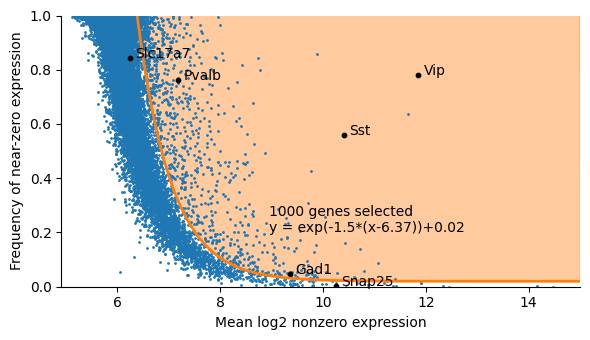

In [23]:
amount_of_genes = 1000
markerGenes = ["Snap25", "Gad1", "Slc17a7", "Pvalb", "Sst", "Vip"]
selectedGenes = geneSelection(
    exonCounts, n=amount_of_genes, threshold=30, markers=markerGenes, genes=gene_names
)
exonCounts = exonCounts[:, selectedGenes]
gene_names = gene_names[selectedGenes]

In [24]:
genes = exonCounts.copy()
genes = (
    genes
    / np.sum(genes, axis=1, keepdims=True)
    * np.median(np.sum(genes, axis=1, keepdims=True))
)
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype("float64")

#### T-sne projection of transcriptome

In [62]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
Z = tsne.fit(G)

# save embedding coordinates
np.savez('./embedding_coordinates/tsne.npz',
     coord=Z,
    )

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.52 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.05 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 3.01 seconds
===> Running optimization with exaggeration=12.00, lr=296.58 for 250 iterations...
Iteration   50, KL divergence 3.1835, 50 iterations in 3.6728 sec
Iteration  100, KL divergence 3.0858, 50 iterations in 3.4754 sec
Iteration  150, KL divergence 3.0863, 50 iterations in 3.3731 sec
Iteration  200, KL divergence 3.0912, 50 iterations in 3.3837 sec
Iteration  250, KL divergence 3.0927, 50 iterations in 3.3681 sec
   --> Time elapsed: 17.27 seconds
===> Running optimization with exaggeration=1

In [25]:
Z = np.load("./embedding_coordinates/tsne.npz")["coord"]

In [26]:
exps_colors = ["darkred", "salmon", "goldenrod", "lightseagreen", "magenta", "purple"]

In [27]:
def create_figure_2(fig):
    if fig is None:
        fig = plt.figure(figsize=(9, 3))
    else:
        fig = fig
    width, height = 0.16, 0.12

    ax_exps = [
        plt.axes([0.15, 0, width, height]),
        plt.axes([0, 0.05, width, height]),
        plt.axes([0.29, 0.22, width, height], zorder=1),
        plt.axes([0, 0.4, width, height]),
        plt.axes([0.02, 0.75, width, height]),
        plt.axes([0.22, 0.66, width, height], zorder=1),
    ]
    ax_sims = [
        plt.axes([0.15, 0.13, width, height]),
        plt.axes([0, 0.18, width, height]),
        plt.axes([0.29, 0.35, width, height]),
        plt.axes([0, 0.53, width, height]),
        plt.axes([0.02, 0.88, width, height]),
        plt.axes([0.22, 0.79, width, height], zorder=1),
    ]
    ax_embed = plt.axes([0.15, 0.3, 0.15, 0.45], zorder=0)
    ax_features = [
        [plt.axes([x, y, 0.07, 0.21]) for y in [0, 0.38, 0.76]]
        for x in [0.48, 0.61, 0.74]
    ]
    return ax_embed, ax_exps, ax_sims, ax_features

In [28]:
features_to_show = [3, 4, 8, 21, 12, 15, 17, 18, 20]

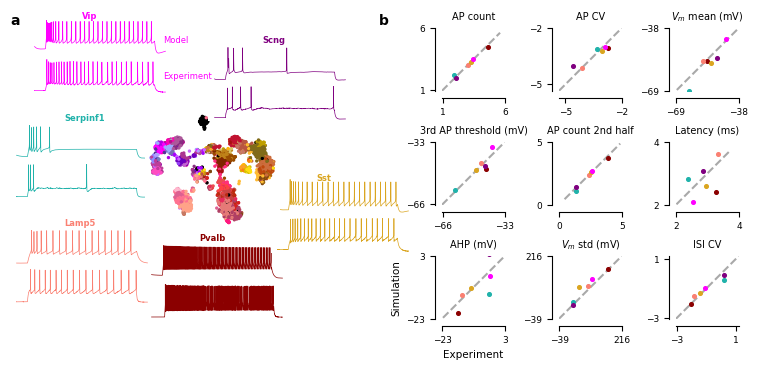

In [29]:
fig = plt.figure(figsize=(9, 3))
ax_embed, ax_exps, ax_sims, ax_features = create_figure_2(fig)
ax_embed.scatter(Z[:, 0], Z[:, 1], s=2, c=colors[non_nans])
ax_embed.set_xticks([])
ax_embed.set_yticks([])
sns.despine(ax=ax_embed, left=True, bottom=True)
for i, ax in enumerate(ax_exps):
    # plot experimental observation
    ax.plot(
        observations[i]["time"],
        observations[i]["data"][0,:],
        lw=0.5,
        c=exps_colors[i],
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)

for i, ax in enumerate(ax_sims):
    # plot best prior simulation
    ax.plot(
        simulations[i]["time"],
        simulations[i]["data"][0, 0, :],
        lw=0.5,
        c=exps_colors[i],
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)


for i, ax in enumerate(np.array(ax_features).reshape(-1)):
    for j in range(6):
        ax.scatter(
            xos[j, features_to_show[i]],
            xs[j, features_to_show[i]],
            color=exps_colors[j],
            s=7,
        )
    std = xos[:, features_to_show[i]].std()
    ax.plot(
        [
            xos[:, features_to_show[i]].min() - 1.1 * std,
            xos[:, features_to_show[i]].max() + 1.1 * std,
        ],
        [
            xos[:, features_to_show[i]].min() - 1.1 * std,
            xos[:, features_to_show[i]].max() + 1.1 * std,
        ],
        "--",
        c="darkgrey",
        zorder=0,
    )
    ax.set_xlim(
        (
            xos[:, features_to_show[i]].min() - 1.1 * std,
            xos[:, features_to_show[i]].max() + 1.1 * std,
        )
    )
    ax.set_ylim(
        (
            xos[:, features_to_show[i]].min() - 1.1 * std,
            xos[:, features_to_show[i]].max() + 1.1 * std,
        )
    )
    ax.set_xticks(
        [
            round(xos[:, features_to_show[i]].min() - 1.1 * std),
            round(xos[:, features_to_show[i]].max() + 1.1 * std),
        ]
    )
    ax.set_yticks(
        [
            round(xos[:, features_to_show[i]].min() - 1.1 * std),
            round(xos[:, features_to_show[i]].max() + 1.1 * std),
        ]
    )
    if i == 0:
        ax.set_xlabel("Experiment", fontsize=7.5)
        ax.set_ylabel("Simulation", fontsize=7.5)
    ax.tick_params(which="both", labelsize=6.5)
    ax.set_title(ephys_features_w_units[features_to_show[i]], fontsize=7)
    adjust_spines(ax, ["left", "bottom"])
    sns.despine(ax=ax)

fs = 6
fig.text(0.17, 0.92, "Model", fontsize=fs, color="magenta")
fig.text(0.17, 0.8, "Experiment", fontsize=fs, color="magenta")
fig.text(0.06, 0.31, "Lamp5", fontsize=fs, color="salmon", fontweight="bold")
fig.text(0.28, 0.92, "Scng", fontsize=fs, color="purple", fontweight="bold")
fig.text(0.06, 0.66, "Serpinf1", fontsize=fs, color="lightseagreen", fontweight="bold")
fig.text(0.08, 1, "Vip", fontsize=fs, color="magenta", fontweight="bold")
fig.text(0.34, 0.46, "Sst", fontsize=fs, color="goldenrod", fontweight="bold")
fig.text(0.21, 0.26, "Pvalb", fontsize=fs, color="darkred", fontweight="bold")
fig.text(0, 0.98, "a", fontsize=10, color="k", fontweight="bold")
fig.text(0.41, 0.98, "b", fontsize=10, color="k", fontweight="bold")

plt.savefig("figure_2_V1.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_2_V1.png", bbox_inches="tight", pad_inches=0)